In [87]:
from astroML.datasets import generate_mu_z
import urllib.request
import pandas as pd
import requests
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from scipy.stats import uniform
from sklearn.mixture import GaussianMixture
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
import scipy.stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from random import randint
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

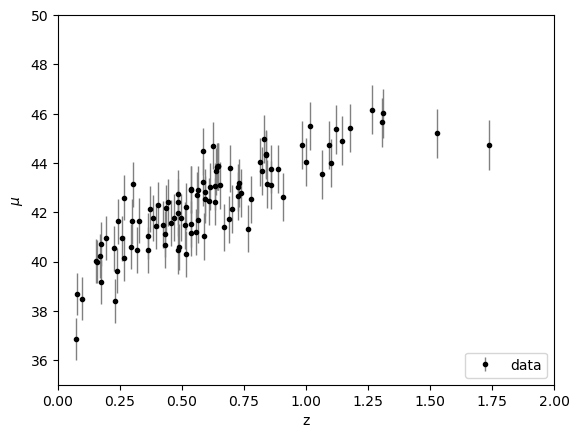

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

z_sample1 = z_sample.reshape(len(z_sample), 1)
z = np.linspace(0.05, 2., 1000)

## Linear Regression

In [3]:
lin_reg = LinearRegression()
lin_reg.fit(z_sample1, mu_sample, sample_weight=1.0/dmu**2)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)
Z_new = np.array([[0], [2]])
mu_pred = lin_reg.predict(Z_new)

39.483846022957295 [4.76438865]


In [4]:
def mu(z):
    return theta0 + theta1*z

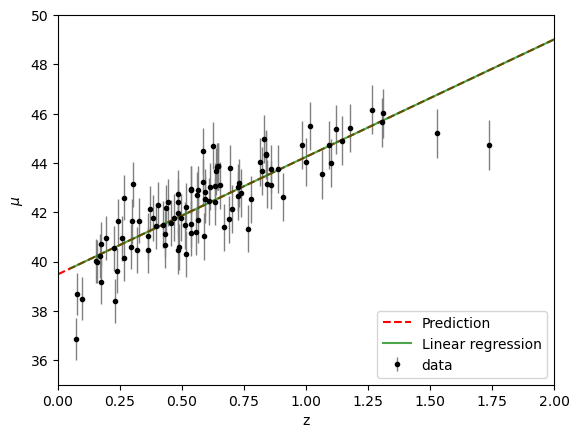

In [5]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(Z_new, mu_pred, color = 'red', label='Prediction', ls = '--')
plt.plot(z, mu(z), color = 'green', label='Linear regression', alpha=0.7)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

## Polynomial Regression

In [6]:
def poly(degree):
    model = PolynomialRegression(degree) # fit 3rd degree polynomial
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    mu_pred_poly = model.predict(z[:,np.newaxis])
    return mu_pred_poly

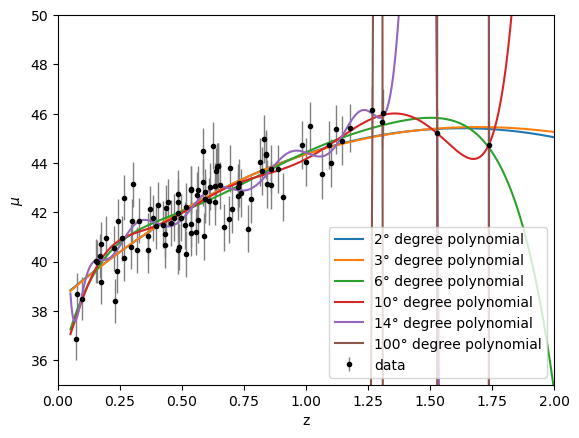

In [7]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, poly(2), label='2° degree polynomial')
plt.plot(z, poly(3), label='3° degree polynomial')
plt.plot(z, poly(6), label='6° degree polynomial')
plt.plot(z, poly(10), label='10° degree polynomial')
plt.plot(z, poly(14), label='14° degree polynomial')
plt.plot(z, poly(100), label='100° degree polynomial')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

## Cross Validation

In [75]:
z_train, z_cross, mudmu_train, mudmu_cross = train_test_split(z_sample[:,np.newaxis], np.array([mu_sample,dmu]).T, test_size=0.3, random_state=42)
mu_train, dmu_train = mudmu_train.T
mu_cross, dmu_cross = mudmu_cross.T

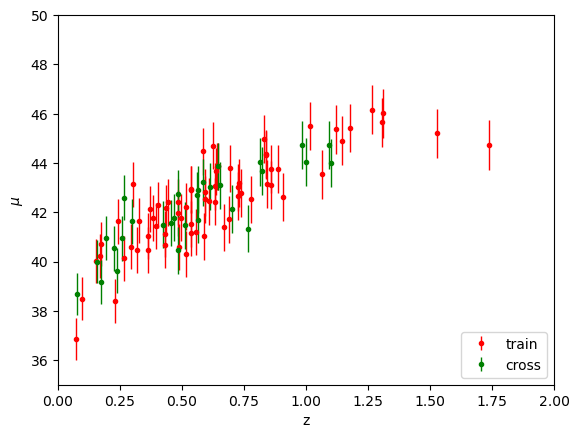

In [76]:
plt.errorbar(z_train, mu_train, dmu_train, fmt='.r', ecolor='red', lw=1,label='train')
plt.errorbar(z_cross, mu_cross, dmu_cross, fmt='.g', ecolor='green', lw=1,label='cross')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

$$\epsilon_{\rm cv/tr} = \sqrt{\frac{1}{n}\sum_{i=1}^{N_{\rm cv/tr}}
  \left[y_i - \sum_{m=0}^d \theta_0^{(n)}x_i^m\right]^2}$$

In [77]:
def rms_error(x_t, y_t, dy_t, x_c, y_c, degree):
    model = PolynomialRegression(degree)
    model.fit(x_t, y_t, dy_t)
    y_pred_t = model.predict(x_t)
    y_pred_c = model.predict(x_c)
    rms_train = np.sqrt(np.sum((y_t - y_pred_t) ** 2)/len(y_t))
    rms_cross = np.sqrt(np.sum((y_c - y_pred_c) ** 2)/len(y_c))
    return rms_train, rms_cross

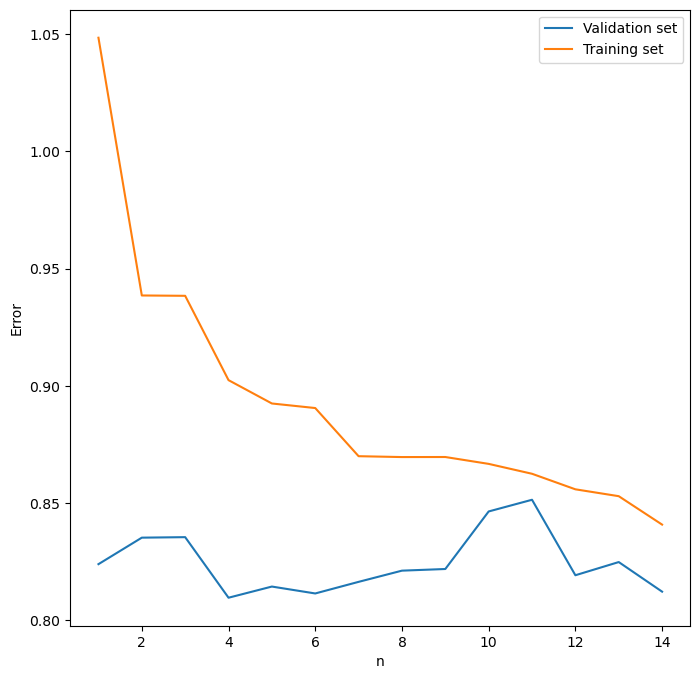

In [83]:
#d = np.arange(0, 21)
nrange = np.arange(1,15)

training_err = np.zeros(len(nrange))
crossval_err = np.zeros(len(nrange))

fig = plt.figure(figsize=(8, 8))
for n in nrange:
    training_err[n-1], crossval_err[n-1] = rms_error(z_train, mu_train, dmu_train, z_cross, mu_cross, n)

plt.plot(nrange, crossval_err, label='Validation set')
plt.plot(nrange, training_err, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend();

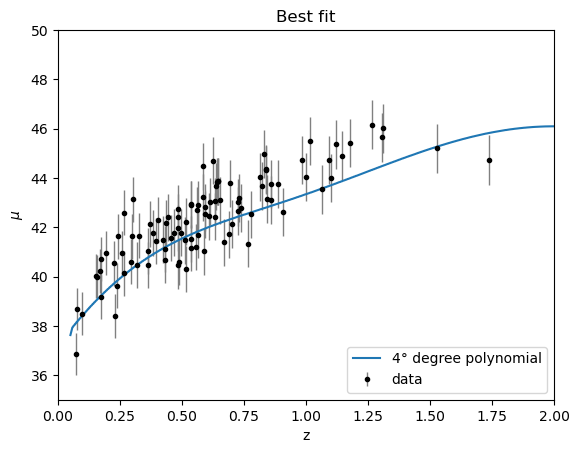

In [85]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, np.sort(poly(4)), label='4° degree polynomial')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Best fit')
plt.xlim(0,2)
plt.ylim(35,50);

## Basis function regression

In [149]:
za = np.sort(z_train.reshape(-1))

In [162]:
# mean positions of the 10 Gaussians in the model
X_gridtest = np.linspace(0,2,10)[:, None]
# widths of these Gaussians
sigma_test = 0.1
model = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=sigma_test)
model.fit(z_train, mu_train, dmu_train)

mu_basis = model.predict(za[:, np.newaxis])

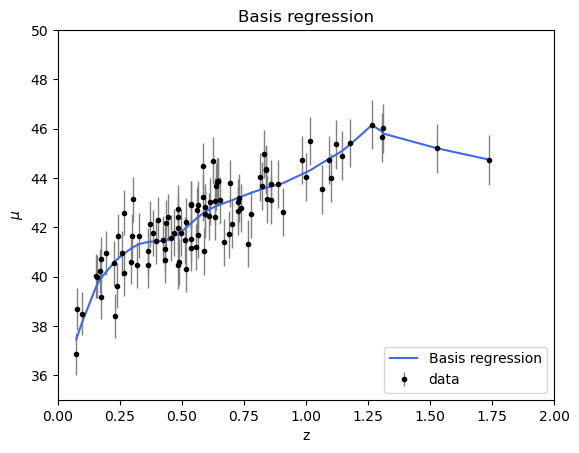

In [169]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(za, mu_basis, label='Basis regression', color='royalblue')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Basis regression')
plt.xlim(0,2)
plt.ylim(35,50);

## Kernerl regression

In [159]:
model = NadarayaWatson(kernel='gaussian', h=0.05)
model.fit(z_train, mu_train, dmu_train)

mu_kernel = model.predict(za[:, np.newaxis])

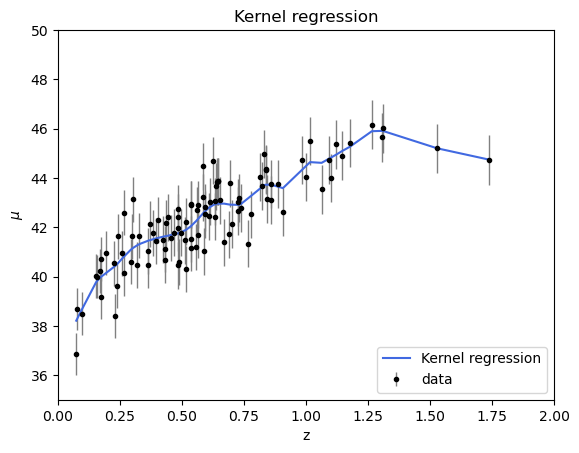

In [167]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(za, mu_kernel, label='Kernel regression', color='royalblue')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Kernel regression')
plt.xlim(0,2)
plt.ylim(35,50);